# Set up

## Change working directory

In [1]:
%cd ../

C:\Users\sritchie\Downloads\tmp\skylar-toolbox-examples


## Import libraries

In [2]:
import datetime
import numpy as np
import pandas as pd
import pathlib
import seaborn as sns; sns.set()
import shutil
import toolz as tz
import warnings
from matplotlib import pyplot as plt
from skylar_toolbox import exploratory_data_analysis as steda 
from skylar_toolbox import utils as stus
try:
    from scripts import utils
    notebook_bl = True
except:
    import utils
    notebook_bl = False
    plt.switch_backend(newbackend='Agg')

# Run in notebook
## Get and set environment variables
import os
## Parse arguments
import argparse
## Read in params
import yaml
## Configure logging
import logging
## Show dir()
from skylar_toolbox import catboost as stcb
## Read in data
from catboost import datasets as cbds
## Preprocess
from feature_engine import imputation as fein
from sklearn import compose as snce
from sklearn import pipeline as snpe
from skylar_toolbox import preprocessing as stpg
## Show my subclasses
import inspect
## Show how update would work
from sklearn import feature_selection as snfs

# Run in notebook

## Get and set environment variables

In [3]:
env_dt = dict(os.environ)
env_dt.setdefault('stage_sr', 'catboost')
env_dt.setdefault('params_file_sr', 'params.yaml')

'params.yaml'

## Parse arguments

In [4]:
ap = argparse.ArgumentParser()
ap.add_argument('--stage_sr', type=str, default=env_dt['stage_sr'])
ap.add_argument('--params_file_sr', type=str, default=env_dt['params_file_sr'])
ns, _ = ap.parse_known_args()

## Read in params

In [5]:
with open(file=ns.params_file_sr) as fh: params_dt = yaml.safe_load(stream=fh)
for key_sr in params_dt:
    exec('%s_dt = params_dt["%s"]' % (key_sr, key_sr))
    exec('%s_directory_ph = pathlib.Path(%s_dt["directory_sr"])' % (key_sr, key_sr))
for key_sr, value_sr in data_dt['columns_dt'].items():
    exec('%s = "%s"' % (key_sr, value_sr))
    if not key_sr.endswith('sr'): exec('%s = eval(%s)' % (key_sr, key_sr))

## Configure logging

In [6]:
outputs_directory_ph /= ns.stage_sr 
shutil.rmtree(path=outputs_directory_ph, ignore_errors=True)
outputs_directory_ph.mkdir()
logging.basicConfig(filename=outputs_directory_ph/str(datetime.date.today()), **notebooks_dt['basic_config_dt'])
logging.info(msg='Configure logging')

## Show dir()

In [7]:
if notebook_bl: display(stus.filter_dir(x=stcb))
logging.info(msg='Show dir()')

,object,under_flag,type,module_flag
0,CatBoostClassifier,False,type,False
1,CatBoostInspector,False,type,False
2,CatBoostRegressor,False,type,False
3,MonoForestInspector,False,type,False
4,ValidationChangeCallback,False,type,False
5,ValidationDifferenceCallback,False,type,False
17,get_evals_result,False,function,False
18,get_selected_features,False,function,False
21,plot_evals_result,False,function,False
22,plot_selected_features,False,function,False


## Read in data

In [8]:
train_df, test_df = data_lt = cbds.adult()
stus.describe_structure(x=data_lt)
logging.info(msg='Read in data')

<class 'tuple'> with 2 elements
- element: 0
  (<class 'pandas.core.frame.DataFrame'>, (32561, 15))
- element: 1
  (<class 'pandas.core.frame.DataFrame'>, (16281, 15))


## Split into target vector and feature matrix

In [9]:
y_train, y_test = targets_lt = list(map(lambda x: x[adult_target_sr], data_lt))
X_train, X_test = features_lt = list(map(lambda x: x.drop(columns=[adult_target_sr]), data_lt))
logging.info(msg='Split into target vector and feature matrix')

## Preprocess

In [10]:
dtypes_ss = X_train.dtypes
missing_values_ss = X_train.isna().sum()
preprocessor = snpe.make_pipeline(
    snce.make_column_transformer(
        (fein.ArbitraryNumberImputer(), snce.make_column_selector(dtype_include='number')),
        remainder=fein.CategoricalImputer(),
        verbose_feature_names_out=False),
    stpg.TypeConverter(),
    stpg.TypeDowncaster()
).set_output(transform='pandas')
with warnings.catch_warnings(action='ignore'): 
    preprocessor.fit(X=X_train)
    X_train, X_test = features_lt = list(map(lambda x: preprocessor.transform(X=x), features_lt))
if notebook_bl:
    display(pd.concat(objs=[dtypes_ss, X_train.dtypes], axis=1, keys=['before', 'after']))
    display(pd.concat(objs=[missing_values_ss, X_train.isna().sum()], axis=1, keys=['before', 'after']))
logging.info(msg='Preprocess')

,before,after
age,float64,Int8
workclass,object,object
fnlwgt,float64,Int32
education,object,object
education-num,float64,Int8
marital-status,object,object
occupation,object,object
relationship,object,object
race,object,object
sex,object,object


,before,after
age,0,0
workclass,1836,0
fnlwgt,0,0
education,0,0
education-num,0,0
marital-status,0,0
occupation,1843,0
relationship,0,0
race,0,0
sex,0,0


## Show my subclasses

My classes subclass the originals, performing an update in the fit method that allows me to handle situations where the cat_features or monotone_constraints change as part of a pipline (see below).

In [11]:
sep_sr = '\n' + '-' * int(8e1) + '\n' * 2
print(inspect.getsource(object=stcb.CatBoostClassifier), inspect.getsource(object=stcb.update_params), sep=sep_sr)
logging.info(msg='Show my subclasses')

class CatBoostClassifier(cb.CatBoostClassifier):
    def fit(self, X, y, **kwargs):
        params_dt = self.get_params()
        params_dt = update_params(params_dt=params_dt, X=X)
        self.set_params(**params_dt)
        return super().fit(X=X, y=y, **kwargs)

--------------------------------------------------------------------------------

def update_params(params_dt, X):
    # Get cat features
    old_cat_features_lt = params_dt.get('cat_features', [])
    new_cat_features_lt = (X.columns
        .intersection(other=old_cat_features_lt)              # May have been dropped
        .union(other=X.select_dtypes(include=object).columns) # May have been added
        .tolist())
    # Get monotone contraints
    old_monotone_constraints_dt = params_dt.get('monotone_constraints', dict())
    if old_monotone_constraints_dt: new_monotone_constraints_dt = {
        key_sr: value_it for key_sr, value_it in old_monotone_constraints_dt.items() if key_sr in X.columns}
    else: new_monotone

## Show how update would work

Some of the columns are redundant (e.g., education and education-num) or not real features (e.g., fnlwgt), etc., but I am ignoring that for the time being to focus on the update process.

In [12]:
cat_features_lt = X_train.select_dtypes(exclude='number').columns.sort_values().tolist()
pipeline = snpe.make_pipeline(
    snfs.SelectFromModel(estimator=stcb.CatBoostClassifier(cat_features=cat_features_lt, **notebooks_dt['cat_boost_dt'])),
    stcb.CatBoostClassifier(cat_features=cat_features_lt, **notebooks_dt['cat_boost_dt'])
).set_output(transform='pandas')
pipeline.fit(X=X_train, y=y_train)
print(sep_sr, end='')
stus.print_sequence(x=pipeline[0].estimator.get_params()['cat_features'], name_sr='Cat features in Step #1')
print(sep_sr, end='')
cat_features_lt = pipeline[1].get_params()['cat_features']
stus.print_sequence(x=cat_features_lt, name_sr='Cat features in Step #2')
logging.info(msg='Show how update would work')

0:	learn: 0.6834866	total: 154ms	remaining: 15.3s
10:	learn: 0.6044455	total: 258ms	remaining: 2.09s
20:	learn: 0.5477136	total: 364ms	remaining: 1.37s
30:	learn: 0.5055194	total: 479ms	remaining: 1.06s
40:	learn: 0.4739910	total: 580ms	remaining: 835ms
50:	learn: 0.4498859	total: 680ms	remaining: 654ms
60:	learn: 0.4311368	total: 776ms	remaining: 496ms
70:	learn: 0.4152032	total: 877ms	remaining: 358ms
80:	learn: 0.4010667	total: 986ms	remaining: 231ms
90:	learn: 0.3904843	total: 1.1s	remaining: 109ms
99:	learn: 0.3826062	total: 1.2s	remaining: 0us
0:	learn: 0.6849090	total: 8.69ms	remaining: 860ms
10:	learn: 0.6173911	total: 90.4ms	remaining: 731ms
20:	learn: 0.5558461	total: 193ms	remaining: 727ms
30:	learn: 0.5107685	total: 314ms	remaining: 699ms
40:	learn: 0.4768645	total: 483ms	remaining: 696ms
50:	learn: 0.4511330	total: 622ms	remaining: 597ms
60:	learn: 0.4314699	total: 766ms	remaining: 490ms
70:	learn: 0.4160879	total: 904ms	remaining: 369ms
80:	learn: 0.4041284	total: 1.06s	r

## Fit my CatBoostInspector

In [13]:
model = pipeline[-1]
inspector = stcb.CatBoostInspector(cbm=model, metrics_lt=notebooks_dt['classification_metrics_lt'])
inspector.fit(X=X_train.loc[:, model.feature_names_], y=y_train, pool_dt=dict(cat_features=cat_features_lt))
logging.info(msg='Fit my CatBoostInspector')

## Generate plots

plot_eval_metrics
--------------------------------------------------------------------------------


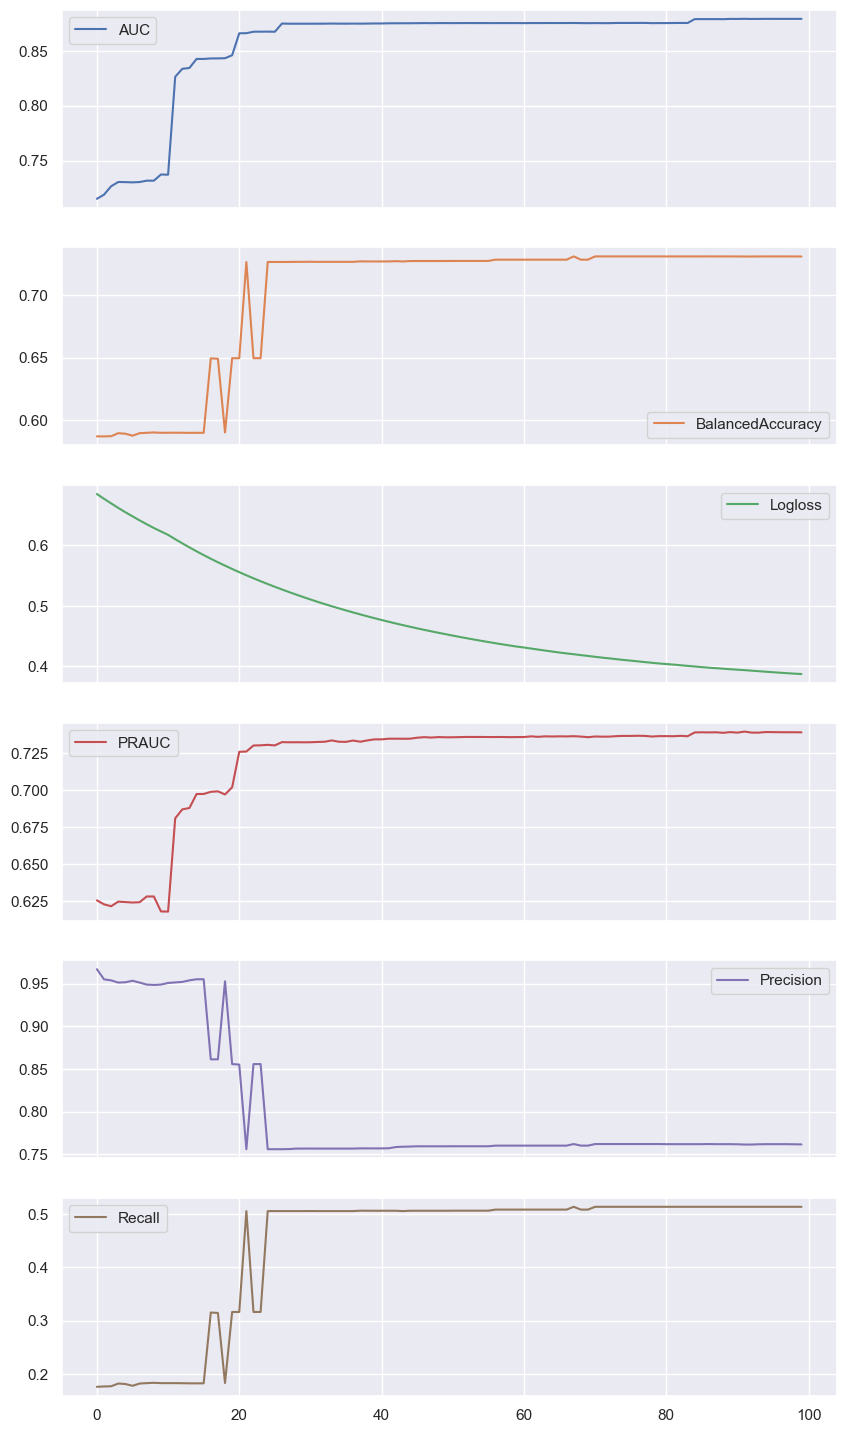

plot_feature_importances
--------------------------------------------------------------------------------


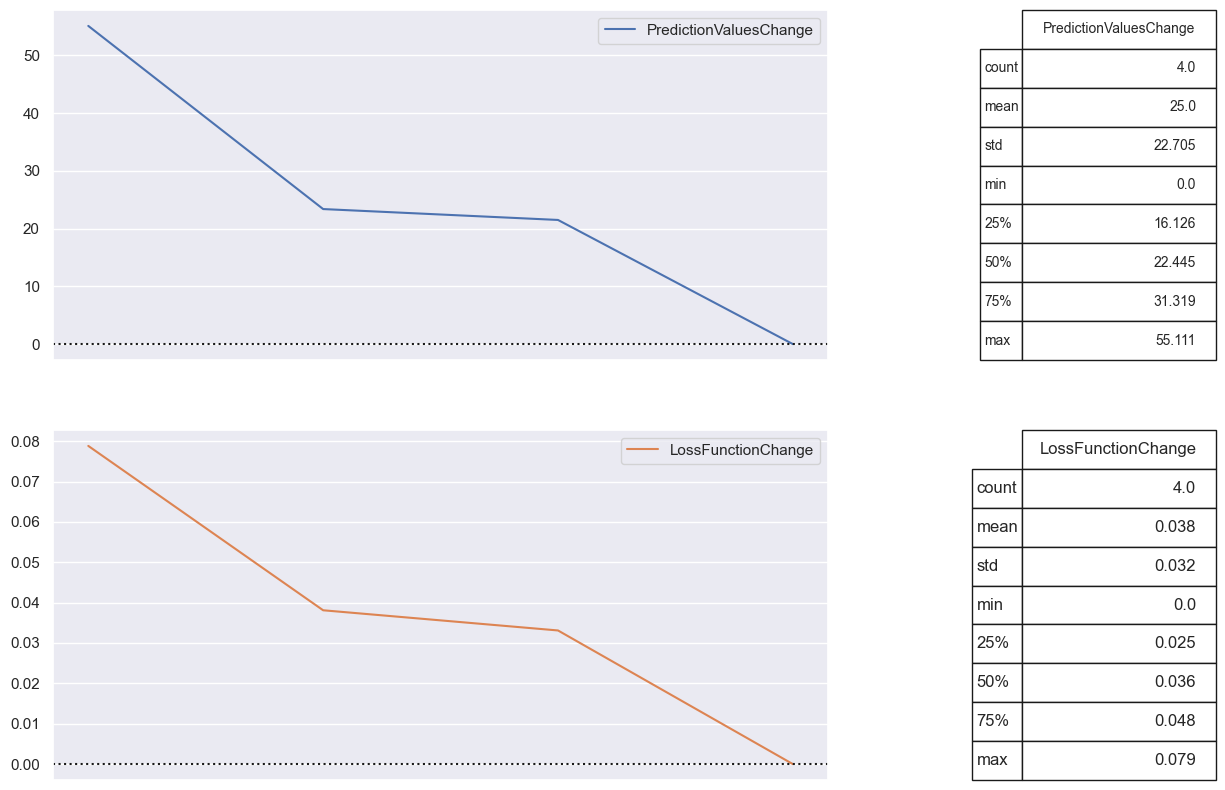

plot_fpr_fnr
--------------------------------------------------------------------------------


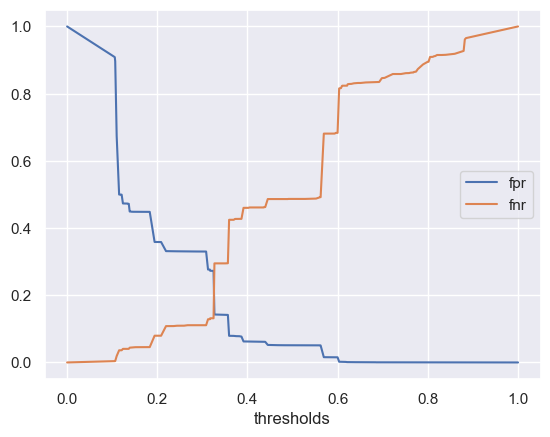

plot_interactions
--------------------------------------------------------------------------------


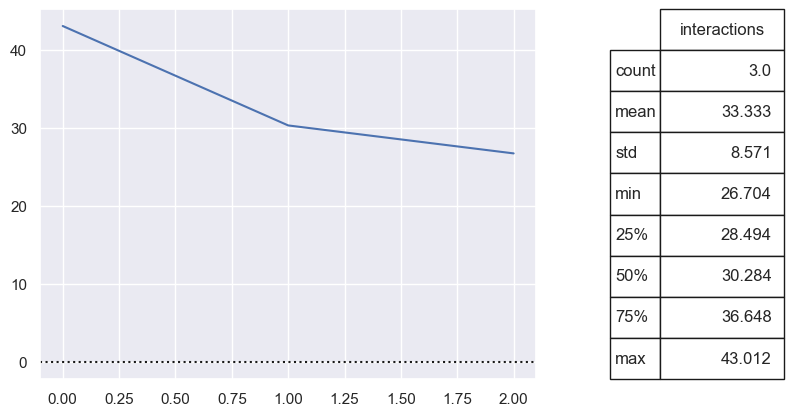

plot_roc_curve
--------------------------------------------------------------------------------


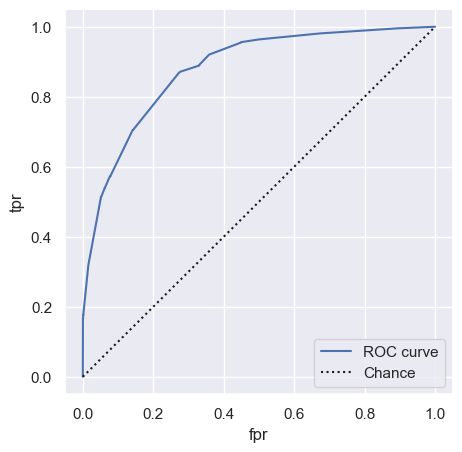

plot_top_feature_importances
--------------------------------------------------------------------------------


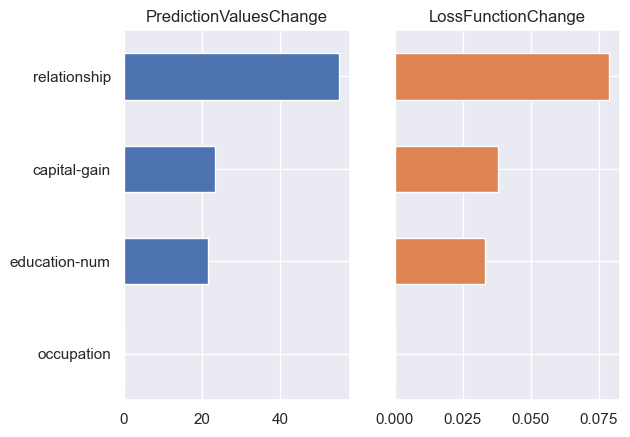

plot_top_interactions
--------------------------------------------------------------------------------


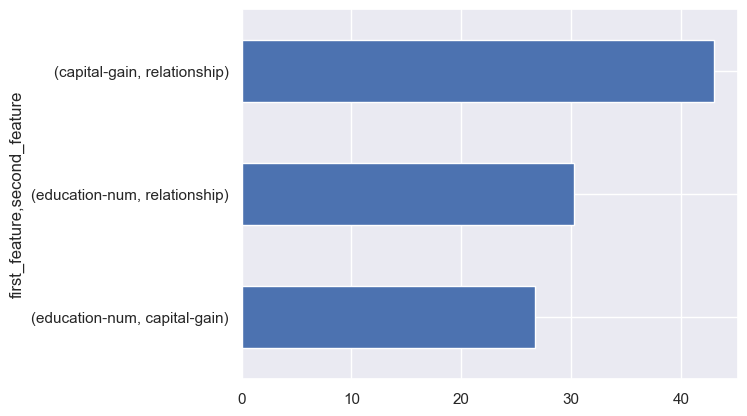

In [14]:
outputs_subdirectory_ph = outputs_directory_ph/'CatBoostInspector'
outputs_subdirectory_ph.mkdir(exist_ok=True)
for method_sr in stus.filter_dir(x=inspector).query(expr='object.str.startswith(pat="plot")')['object']:
    print('=' * int(8e1), method_sr, '-' * int(8e1), sep='\n')
    getattr(inspector, method_sr)()
    plt.savefig(fname=outputs_subdirectory_ph/method_sr, bbox_inches='tight')
    if notebook_bl: plt.show()
    plt.close()
stus.write_readme(outputs_directory_ph=outputs_subdirectory_ph)
logging.info(msg='Generate plots')

## Show data frames

In [15]:
for attribute_sr in stus.filter_dir(x=inspector).query(expr='object.str.endswith(pat="df")')['object']:
    print('=' * int(8e1), attribute_sr, '-' * int(8e1), sep='\n')
    df = getattr(inspector, attribute_sr)
    df.to_csv(path_or_buf=outputs_subdirectory_ph/f'{attribute_sr}.csv')
    if notebook_bl: display(df)
logging.info(msg='Show data frames')

eval_metrics_df
--------------------------------------------------------------------------------


,AUC,BalancedAccuracy,Logloss,PRAUC,Precision,Recall
0,0.715058,0.586985,0.684909,0.625348,0.967041,0.175870
1,0.718871,0.586939,0.676943,0.622654,0.955141,0.176508
2,0.726522,0.587090,0.669394,0.621370,0.953920,0.176891
3,0.730395,0.589520,0.661893,0.624491,0.951333,0.181992
4,0.730282,0.589093,0.654790,0.624188,0.951743,0.181099
...,...,...,...,...,...,...
95,0.879202,0.731198,0.390473,0.739139,0.761734,0.513327
96,0.879203,0.731198,0.389662,0.739071,0.761734,0.513327
97,0.879200,0.731198,0.388874,0.739052,0.761734,0.513327
98,0.879210,0.731178,0.388110,0.739047,0.761589,0.513327


feature_importances_df
--------------------------------------------------------------------------------


,PredictionValuesChange,LossFunctionChange
relationship,55.110616,0.078828
capital-gain,23.387911,0.038107
education-num,21.501472,0.033107
occupation,0.000000,0.000000


interactions_df
--------------------------------------------------------------------------------


,first_feature,second_feature,interactions
0,capital-gain,relationship,43.011698
1,education-num,relationship,30.284444
2,education-num,capital-gain,26.703858


thresholded_metrics_df
--------------------------------------------------------------------------------


,fpr,tpr,fnr
thresholds,,,
1.000000,0.000000,0.000000,1.000000
0.884626,0.000040,0.034689,0.965311
0.882022,0.000040,0.038643,0.961357
0.879365,0.000081,0.072822,0.927178
0.859685,0.000081,0.081367,0.918633
...,...,...,...
0.115347,0.499717,0.963780,0.036220
0.109916,0.673786,0.980997,0.019003
0.106669,0.896359,0.995664,0.004336


## Write README

In [16]:
stus.write_readme(outputs_directory_ph=outputs_directory_ph)
logging.info(msg='Write README')